In [ ]:
from together import Together
import pandas as pd
import math
import os
import fitz  # PyMuPDF
import docx
import faiss
import numpy as np
import requests
import textwrap


TOGETHER_API_KEY = "TOGETHER_API_KEY"

In [89]:
client = Together(api_key="838b47d168be924ab85852a280db529de942eb45be7a2272f29dd09805aa5f09")

def ask_llama(prompt) :
    response = client.chat.completions.create(
        model="meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
        messages=[
        {
            "role": "system",
            "content": "you must read contents of provided files and generate good analysis of the data provided. Answer questions based on the content given."
        },
        {
            "role": "user",
            "content": prompt
        }
        ]
    )
    return response.choices[0].message.content

In [62]:
def summarize_large_dataframe(df, max_rows=500, chunk_size=100):
    summary_parts = []

    # 1. Schema Summary
    schema = f"Dataset has {df.shape[0]} rows and {df.shape[1]} columns.\n"
    schema += "Columns and data types:\n" + df.dtypes.to_string()
    summary_parts.append(schema)

    # 2. Nulls and Uniques
    nulls = df.isnull().sum()
    uniques = df.nunique()
    null_info = "\nNull Values per Column:\n" + nulls.to_string()
    uniq_info = "\nUnique Values per Column:\n" + uniques.to_string()
    summary_parts.append(null_info + uniq_info)

    # 3. Basic Stats
    stats = df.describe(include='all').transpose()
    stats_info = "\nDescriptive Stats (numeric and categorical):\n" + stats.to_string()
    summary_parts.append(stats_info)

    # 4. Stratified Sampling of Rows Across Dataset
    total_rows = len(df)
    if total_rows <= max_rows:
        sampled_df = df.copy()
    else:
        stride = max(total_rows // max_rows, 1)
        indices = list(range(0, total_rows, stride))[:max_rows]
        sampled_df = df.iloc[indices].reset_index(drop=True)

    # 5. Split into Chunks
    chunk_list = []
    num_chunks = math.ceil(len(sampled_df) / chunk_size)
    for i in range(num_chunks):
        chunk_df = sampled_df.iloc[i * chunk_size:(i + 1) * chunk_size]
        chunk_text = f"Data Chunk {i+1} of {num_chunks}:\n" + chunk_df.to_string(index=False)
        chunk_list.append(chunk_text)

    # 6. Return Combined Prompt Chunks
    return summary_parts + chunk_list


In [63]:
def csv_prompt_builder(file_path, max_rows=500, chunk_size=100):
    try:
        df = pd.read_csv(file_path)
    except UnicodeDecodeError:
        df = pd.read_csv(file_path, encoding="ISO-8859-1")

    # Generate prompt-ready chunks (summaries + stratified data)
    chunks = summarize_large_dataframe(df, max_rows=max_rows, chunk_size=chunk_size)

    # Create LLM prompts from each chunk
    prompt_chunks = []
    for i, chunk in enumerate(chunks):
        prompt = f"""
You are a data analyst. Analyze the following dataset segment {i+1}:

{chunk}

Please describe any trends, patterns, anomalies, or summary insights you observe in this segment.
"""
        prompt_chunks.append(prompt.strip())

    csv_prompt = "\n\n".join(prompt_chunks)  # or summarize_large_dataframe(df)
    return csv_prompt

In [64]:
csv_prompt = csv_prompt_builder("Sample - Superstore.csv")
csv_prompt

'You are a data analyst. Analyze the following dataset segment 1:\n\nDataset has 9994 rows and 21 columns.\nColumns and data types:\nRow ID             int64\nOrder ID          object\nOrder Date        object\nShip Date         object\nShip Mode         object\nCustomer ID       object\nCustomer Name     object\nSegment           object\nCountry           object\nCity              object\nState             object\nPostal Code        int64\nRegion            object\nProduct ID        object\nCategory          object\nSub-Category      object\nProduct Name      object\nSales            float64\nQuantity           int64\nDiscount         float64\nProfit           float64\n\nPlease describe any trends, patterns, anomalies, or summary insights you observe in this segment.\n\nYou are a data analyst. Analyze the following dataset segment 2:\n\n\nNull Values per Column:\nRow ID           0\nOrder ID         0\nOrder Date       0\nShip Date        0\nShip Mode        0\nCustomer ID      0\nCus

In [90]:
response = ask_llama(csv_prompt)
print(response)

### Analysis of Dataset Segments

#### Segment 1: Dataset Overview

The dataset has 9994 rows and 21 columns, with a mix of integer, object, float64, and int64 data types. The columns include identifiers (Row ID, Order ID, Customer ID, Product ID), dates (Order Date, Ship Date), categorical data (Ship Mode, Segment, Category, Sub-Category), and numerical data (Sales, Quantity, Discount, Profit).

*   **Initial Observations:**
    *   The dataset appears to be related to sales data, with columns for sales, quantity, discount, and profit.
    *   The presence of customer and product information suggests that the data could be used for customer segmentation, product analysis, or sales forecasting.

#### Segment 2: Null Values and Unique Values per Column

The dataset has no null values across all columns. The number of unique values per column varies, with some columns having a large number of unique values (e.g., Row ID, Order ID, Order Date) and others having relatively few (e.g., Ship 

In [66]:
# === TEXT EXTRACTORS ===
def extract_text_from_pdf(file_path):
    doc = fitz.open(file_path)
    return "\n".join([page.get_text() for page in doc])

def extract_text_from_docx(file_path):
    document = docx.Document(file_path)
    return "\n".join([p.text for p in document.paragraphs if p.text.strip()])

def extract_text_from_txt(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        return f.read()
    
# === TEXT CHUNKING ===
def chunk_text(text, max_words=300):
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_words):
        chunk = " ".join(words[i: i+max_words])
        chunks.append(chunk)
    return chunks

# === TOGETHER EMBEDDING CALL ===
def embed_text(texts):
    url = "https://api.together.xyz/v1/embeddings"
    headers = {
        "Authorization": f"Bearer {TOGETHER_API_KEY}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "togethercomputer/m2-bert-80M-8k-retrieval",  # embedding model
        "input": texts
    }
    response = requests.post(url, headers=headers, json=payload)
    vectors = [item['embedding'] for item in response.json()['data']]
    return np.array(vectors).astype('float32')

# === BUILD VECTOR DB ===
def build_faiss_index(chunks):
    embeddings = embed_text(chunks)
    dim = embeddings.shape[1]
    index = faiss.IndexFlatL2(dim)
    index.add(embeddings)
    return index, embeddings, chunks

In [81]:
def process_document_file(file_path):
    ext = os.path.splitext(file_path)[1].lower()

    if ext == ".pdf":
        raw_text = extract_text_from_pdf(file_path)
    elif ext == ".docx":
        raw_text = extract_text_from_docx(file_path)
    elif ext == ".txt":
        raw_text = extract_text_from_txt(file_path)
    else:
        raise ValueError("Unsupported file type. Only .pdf, .docx, and .txt are supported.")
    
    chunks = chunk_text(raw_text)
    embeddings = embed_text(chunks)

    dim = embeddings.shape[1]
    index = faiss.IndexFlatL2(dim)
    index.add(embeddings)

    return index, embeddings, chunks

In [74]:
def query_llama_with_doc(question, index, chunk_store, top_k=3):
    # === Step 1: Embed the question ===
    embedding_url = "https://api.together.xyz/v1/embeddings"
    headers = {
        "Authorization": f"Bearer {TOGETHER_API_KEY}",
        "Content-Type": "application/json"
    }
    payload = {
        "model": "togethercomputer/m2-bert-80M-8k-retrieval",
        "input": [question]
    }
    response = requests.post(embedding_url, headers=headers, json=payload)
    question_vec = np.array(response.json()['data'][0]['embedding'], dtype='float32').reshape(1, -1)

    # === Step 2: Retrieve top-k similar chunks ===
    distances, indices = index.search(question_vec, top_k)
    top_chunks = [chunk_store[i] for i in indices[0]]

    # === Step 3: Build prompt ===
    context_text = "\n\n".join([f"Chunk {i+1}:\n{c}" for i, c in enumerate(top_chunks)])
    final_prompt = f"""
You are a helpful data analyst. Based on the following extracted document content, answer the user's question.

{context_text}

Question: {question}
"""

    # === Step 4: Query LLaMA on Together ===
    chat_url = "https://api.together.xyz/v1/chat/completions"
    chat_payload = {
        "model": "meta-llama/Llama-4-Maverick-17B-128E-Instruct-FP8",
        "messages": [
            {"role": "system", "content": "You are a helpful data analyst."},
            {"role": "user", "content": final_prompt}
        ]
    }
    chat_response = requests.post(chat_url, headers=headers, json=chat_payload)
    return chat_response.json()['choices'][0]['message']['content']

In [75]:
index, _, chunk_store = process_document_file("tata-motor-IAR-2024-25.pdf")

response = query_llama_with_doc(
    question="What business issues are highlighted in the report?",
    index=index,
    chunk_store=chunk_store,
    top_k=4
)

print(response)


The business issues highlighted in the report relate to Diversity, Equity, and Inclusion (DEI) and Prevention of Sexual Harassment (POSH) at the workplace. The report highlights the company's efforts to create a more inclusive and equitable workplace culture, including:

1. Promoting gender diversity and inclusion through various initiatives such as empowHER, a flagship empowerment program for women professionals.
2. Ensuring equal opportunities for persons with disabilities (PWDs) and onboarding PWD employees.
3. Addressing sexual harassment at the workplace through a comprehensive POSH policy, Internal Committees, and awareness workshops.
4. Fostering a culture of inclusivity through sensitization programs, such as ONEderful Conversations, to raise awareness and dispel myths among employees.

The report also highlights the company's progress in these areas, including:

1. An improvement in the gender diversity ratio to 11.1% in FY25.
2. A decline in attrition among women employees by

In [84]:
index, _, chunk_store = process_document_file("sample.txt")

response = query_llama_with_doc(
    question="Summarize the discussion points and decisions made.",
    index=index,
    chunk_store=chunk_store,
    top_k=3
)

print(response)


Based on the provided document content, here is a summary of the discussion points and decisions made:

**Key Performance Highlights (Q1 2025)**

1. Marketing:
	* Spent $42,000 on campaigns, generating 1,850 qualified leads.
	* Email marketing outperformed paid ads, converting 320 leads vs. 215 leads.
2. Sales:
	* Closed 610 deals out of 1,850 leads, with a 33% conversion rate.
	* Total revenue generated: $285,000.
	* Average deal size increased to $467 from $420 in Q4 2024.
3. Product:
	* Resolved 120 customer feature requests with an average resolution time of 4.2 days.
	* Launched 3 major features, impacting 80% of users.
4. Customer Support:
	* Handled 3,200 support tickets with a 92.5% satisfaction rating.
	* Average response time improved from 5.1 hours to 3.4 hours.

**Decisions and Recommendations**

1. Increase investment in email marketing due to its higher conversion rate.
2. Explore upselling opportunities in high-value deals, as the average deal size has increased.
3. Focu

In [101]:
import matplotlib.pyplot as plt

def generate_visualization_from_question(question, df):
    # Step 1: Prepare sample data to help LLaMA understand df structure
    df_sample = df.head(10).to_string()

    # Step 2: Ask LLaMA to generate Python plot code
    prompt = f"""
You are a data analyst and Python expert.

Below is a sample of a pandas DataFrame. Based on the user's request, generate pure Python code using matplotlib or seaborn. 
**Do NOT include markdown formatting, code blocks, or explanations. Just return raw executable code.**

Use the variable `df` directly in the code.

Sample DataFrame:
{df_sample}

Task: {question}
"""

    # Get generated code from LLaMA
    code_str = ask_llama(prompt)
    print("Generated Code: \n", code_str)

    if code_str.startswith("```"):
        code_str = "\n".join(line for line in code_str.splitlines() if not line.strip().startswith("```"))

    # Step 3: Execute the generated code with df in context
    global_vars = {
        "df": df,
        "plt": plt,
        "sns": __import__('seaborn')
    }

    try:
        exec(code_str, global_vars)
    except Exception as e:
        print("Error while executing generated code:", e)

Generated Code: 
 import matplotlib.pyplot as plt

region_profit = df.groupby('Region')['Profit'].sum().reset_index()
plt.figure(figsize=(10,6))
plt.bar(region_profit['Region'], region_profit['Profit'], color='skyblue')
plt.xlabel('Region')
plt.ylabel('Total Profit')
plt.title('Total Profit by Region')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


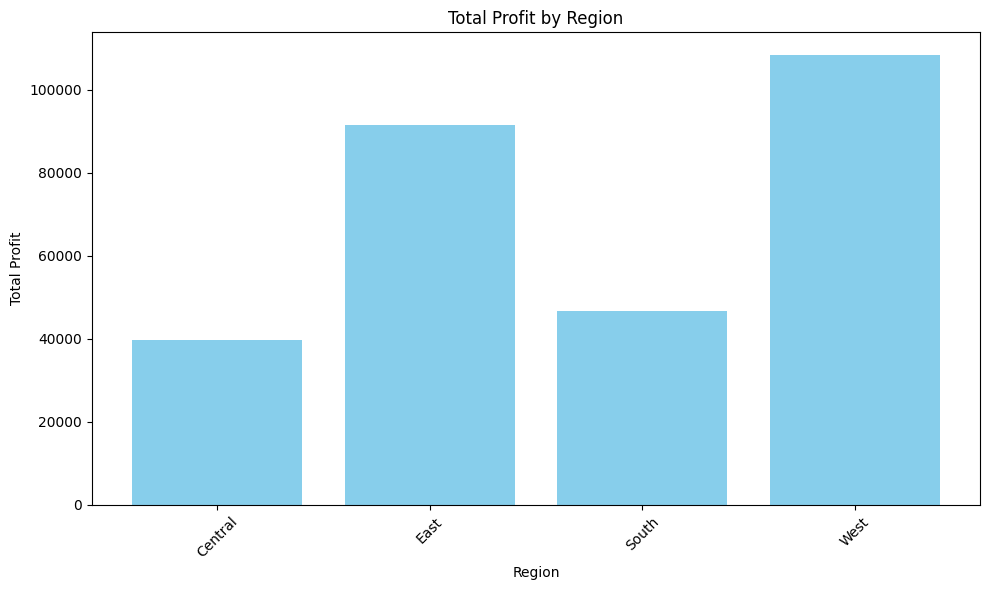

In [103]:
file_path = "Sample - Superstore.csv"
try:
        df = pd.read_csv(file_path)
except UnicodeDecodeError:
        df = pd.read_csv(file_path, encoding="ISO-8859-1")
        
generate_visualization_from_question("Plot total profit by region", df)